In [1]:
# Run once
%cd ..

/Users/lena/modconn/harvard_cs282_ptg


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import datasets
from datasets.tabular import TabularModelPerturb
import torch
from datasets import get_model_class
from util import get_statistics
from similarity import get_top_k, average_pairwise_score, top_k_sa, average_ground_truth_score
from style import bold
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

In [7]:
name = 'heloc'  # or 'german'
n_models = 1000  # 1000 for german if needed
random_sources = ['rs', 'loo']
trainset, testset = datasets.load_dataset(name)

# Random source
random_source = random_sources[0]

X_test, y_test = testset.data.numpy(), testset.labels.numpy()
n_inputs, input_size = X_test.shape
model_args = [input_size, datasets.tabular.layers[name]]
# optim = 'adam'
# epochs = 30
# batch_size = 32
# lr = 0.0004
optim = 'sgd'
epochs = 20
epochs_mode = 30
lr = 0.1
batch_size = 64
dropout = 0
directory = f'models/{name}/{random_source}/{optim}_epochs{epochs}_lr{lr}_batch{batch_size}_dropout{dropout}'
directory_mode = f'models/{name}/{random_source}/{optim}_epochs{epochs_mode}_lr{lr}_batch{batch_size}_dropout{dropout}'
print(bold("Directory:"), directory)
print(bold("Directory mode:"), directory_mode)

def load_model(idx):
    model_class = get_model_class(name)
    model = model_class(*model_args)
    state_dict = torch.load(f'{directory}/model_{idx}.pth')
    model.load_state_dict(state_dict)
    return model

Directory: models/heloc/rs/sgd_epochs20_lr0.1_batch64_dropout0
Directory mode: models/heloc/rs/sgd_epochs30_lr0.1_batch64_dropout0


### Path to Glory

In [6]:
# Ensemble sizes
ensemble_sizes = [2, 4, 6, 8, 10, 20, 30]

# Number of ensembles to sample for each ensemble size
n_trials = 20

# Top-k features to consider
k = 5

# Store no. inputs and no. features
n_inputs, n_features = X_test.shape

In [8]:
methods = ['perturb', 'average', 'majority', 'mode connect']
topk = np.zeros((len(methods), len(ensemble_sizes), n_trials, n_inputs, k))
signs = np.zeros((len(methods), len(ensemble_sizes), n_trials, n_inputs, k), dtype=int)
test_accs = np.zeros((len(methods), len(ensemble_sizes), n_trials))

for e, ensemble_size in enumerate(tqdm(ensemble_sizes)):
    for i in range(n_trials):
        # Sample models
        model_idx = np.random.choice(n_models, ensemble_size, replace=False)
        for j, method in enumerate(methods):
            dir = directory_mode if method == 'mode connect' else directory
            grads, preds = get_statistics(model_idx, method, dir)
            topk[j, e, i], signs[j, e, i] = get_top_k(k=k, X=grads, return_sign=True)
            test_accs[j, e, i] = (preds == y_test).mean()

100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


In [9]:
similarities = np.zeros((len(methods), len(ensemble_sizes), n_inputs))
for e, ensemble_size in enumerate(tqdm(ensemble_sizes)):
    for i, method in enumerate(methods):
        similarities[i, e] = average_pairwise_score(topk[i, e], signs[i, e], top_k_sa)

100%|██████████| 7/7 [01:16<00:00, 10.90s/it]


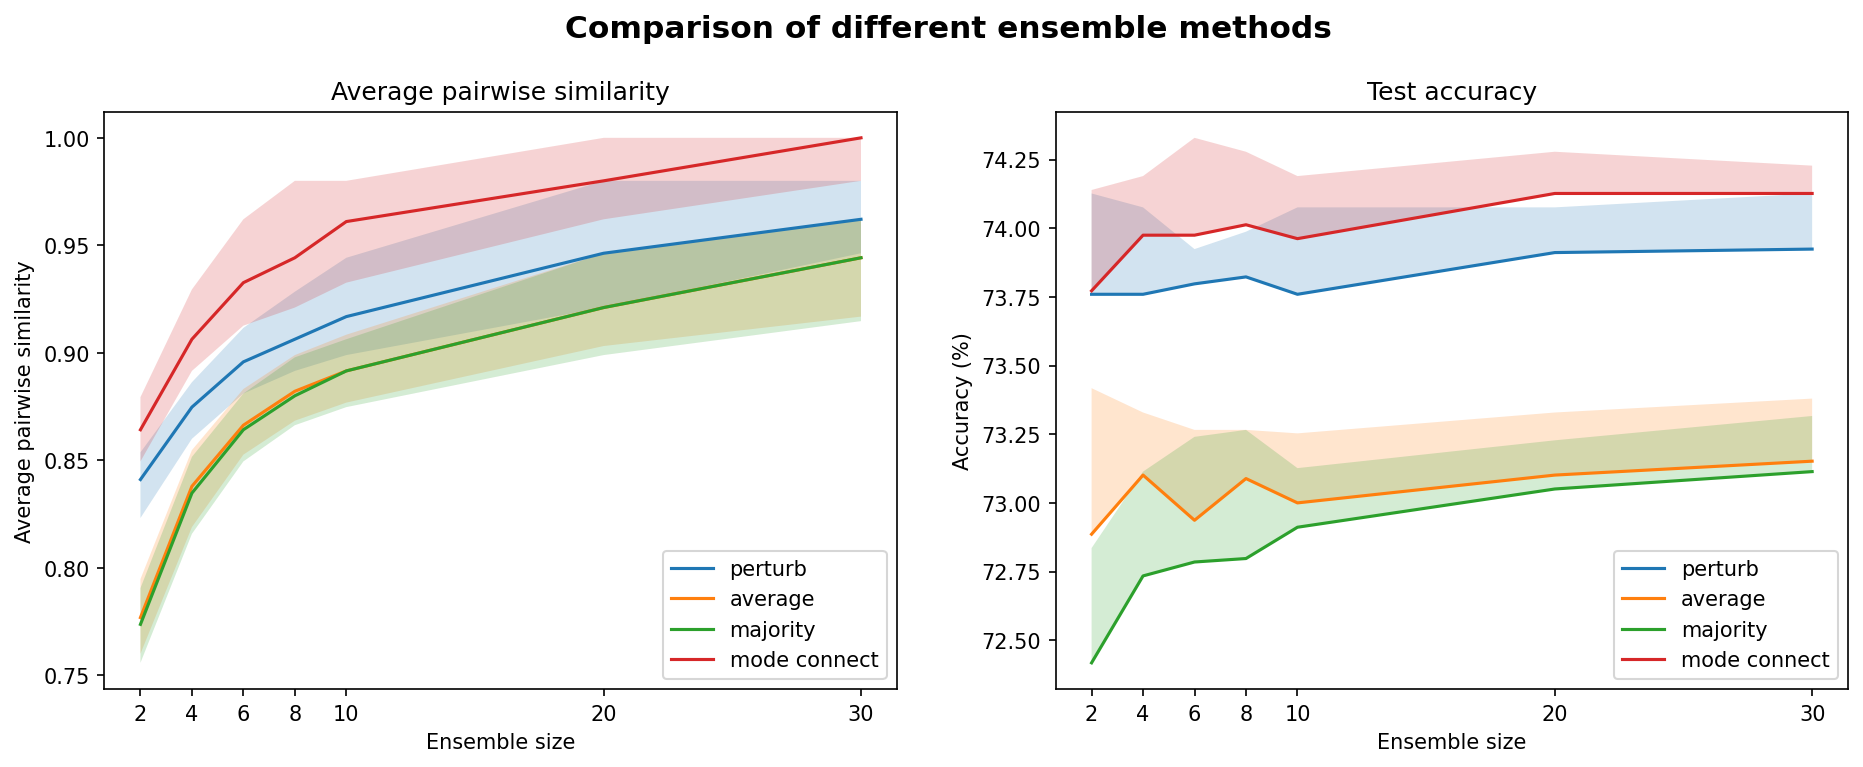

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=150)
plt.suptitle('Comparison of different ensemble methods', fontweight='bold', y=1.01, fontsize=15)
titles = ['Average pairwise similarity', 'Test accuracy']
ylabs = ['Average pairwise similarity', 'Accuracy (%)']

for i, method in enumerate(methods):
    q = np.quantile(similarities[i], [0.4, 0.5, 0.6], axis=1)
    ax[0].plot(ensemble_sizes, q[1], label=method)
    ax[0].fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)
    q = np.quantile(100*test_accs[i], [0.25, 0.75], axis=1)
    ax[1].plot(ensemble_sizes, q[0], label=method)
    ax[1].fill_between(ensemble_sizes, q[0], q[1], alpha=0.2)

for i in range(2):
    ax[i].set_xlabel('Ensemble size')
    ax[i].set_xticks(ensemble_sizes)
    ax[i].legend(loc='lower right')
    ax[i].set_ylabel(ylabs[i])
    ax[i].set_title(titles[i])

plt.show()

### Plot Metrics (need to adjust similarity_metrics.py to suit our uses)

In [14]:
# Similarity between ensembles
SA_avg = np.zeros((len(ensemble_sizes), n_inputs))
SA_perturb = np.zeros((len(ensemble_sizes), n_inputs))

# Similarity to gradient ground truth
SA_avg_gt = np.zeros((len(ensemble_sizes), n_inputs))
SA_perturb_gt = np.zeros((len(ensemble_sizes), n_inputs))

# Similarity to perturbed gradient ground truth
SA_avg_gt_perturb = np.zeros((len(ensemble_sizes), n_inputs))
SA_perturb_gt_perturb = np.zeros((len(ensemble_sizes), n_inputs))

grads = np.array([np.load(f'{directory}/grads_{idx}.npy') for idx in range(n_models)])
gt, signs_gt = get_top_k(k, grads.mean(axis=0), return_sign=True)

grads_perturb = np.array([np.load(f'{directory}/grads_perturb_{idx}.npy') for idx in range(n_models)])
gt_perturb, signs_gt_perturb = get_top_k(k, grads_perturb.mean(axis=0), return_sign=True)

for i in tqdm(range(len(ensemble_sizes))):
    SA_avg[i] = average_pairwise_score(topk_avg[i], signs_avg[i], top_k_sa)
    SA_perturb[i] = average_pairwise_score(topk_perturb[i], signs_perturb[i], top_k_sa)
    
    SA_avg_gt[i] = average_ground_truth_score(topk_avg[i], signs_avg[i], gt, signs_gt, top_k_sa)
    SA_perturb_gt[i] = average_ground_truth_score(topk_perturb[i], signs_perturb[i], gt, signs_gt, top_k_sa)

    SA_avg_gt_perturb[i] = average_ground_truth_score(topk_avg[i], signs_avg[i], gt_perturb, signs_gt_perturb, top_k_sa)
    SA_perturb_gt_perturb[i] = average_ground_truth_score(topk_perturb[i], signs_perturb[i], gt_perturb, signs_gt_perturb, top_k_sa)

100%|██████████| 10/10 [01:08<00:00,  6.84s/it]


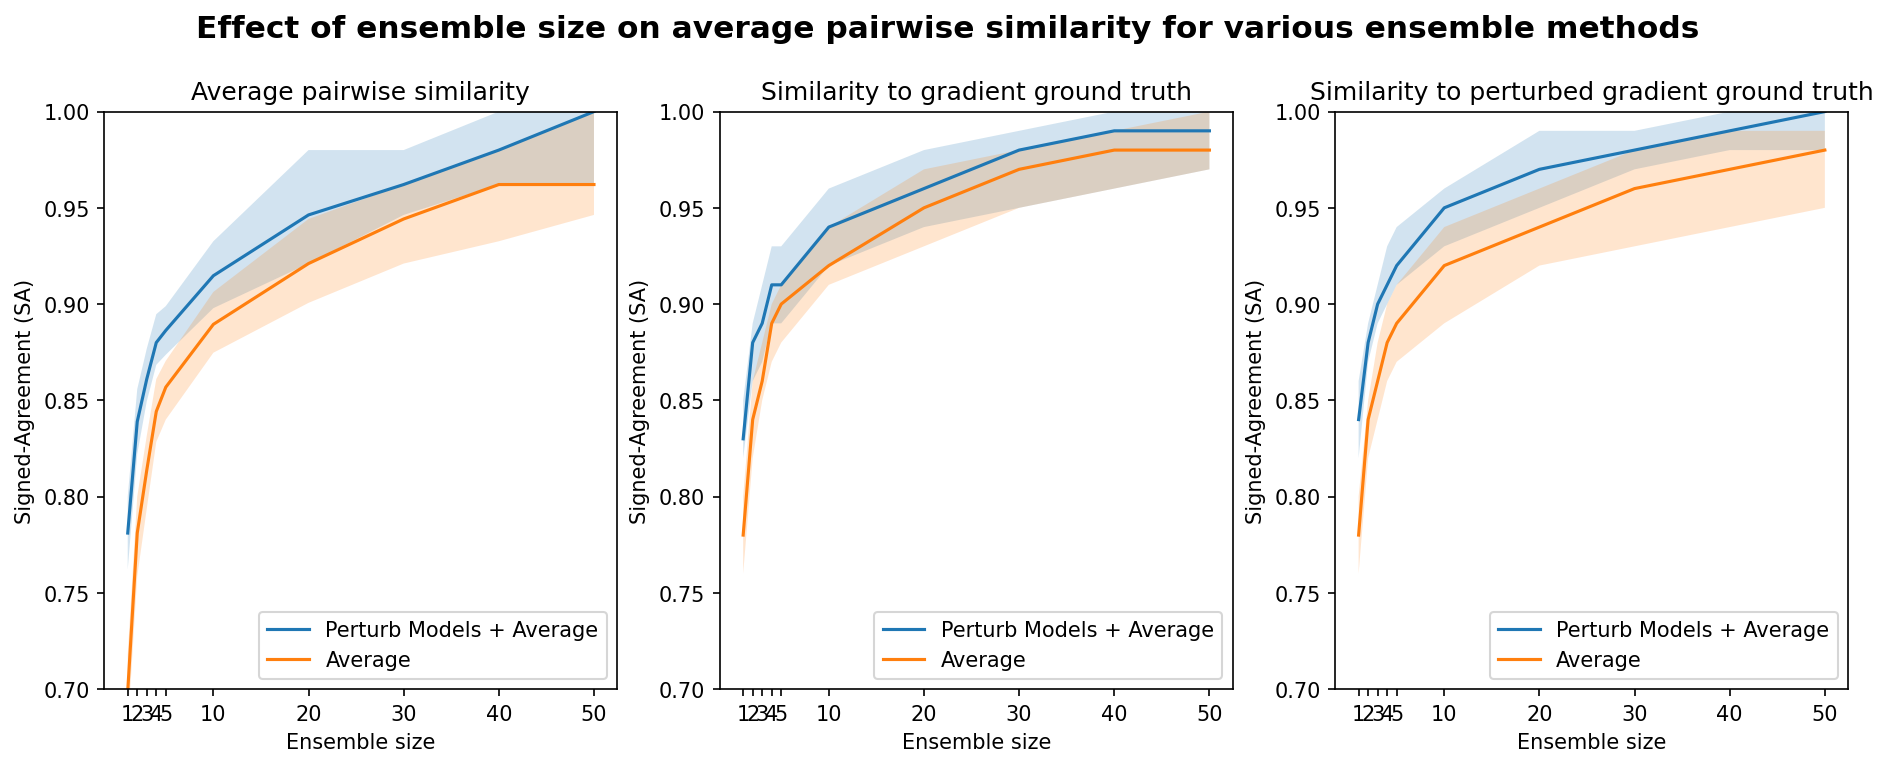

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=150)
labels = ['Perturb Models + Average', 'Average']
metrics = [[SA_perturb, SA_avg],
           [SA_perturb_gt, SA_avg_gt],
           [SA_perturb_gt_perturb, SA_avg_gt_perturb]]
titles = ['Average pairwise similarity', 'Similarity to gradient ground truth', 'Similarity to perturbed gradient ground truth']
plt.suptitle('Effect of ensemble size on average pairwise similarity for various ensemble methods', fontweight='bold', y=1.01, fontsize=15)
for i in range(3):
    for j, metric in enumerate(metrics[i]):
        q = np.quantile(metric, [0.4, 0.5, 0.6], axis=1)
        ax[i].plot(ensemble_sizes, q[1], label=labels[j])
        ax[i].fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)
    ax[i].set_xlabel('Ensemble size')
    ax[i].set_title(titles[i])
    ax[i].set_ylim(0.7, 1)
    ax[i].set_xticks(ensemble_sizes)
    ax[i].set_ylabel('Signed-Agreement (SA)')
    ax[i].legend(loc='lower right')
plt.show()

### Misc Plots

### How to load/visualize gradients

Okay so some gradients are zero... moreso if you do softmax gradient instead of logit gradient

Might just be a floating point error (could try float64 instead of float32 but will double the storage size)

softmax gradient and logit gradient should be the same (?), just softmax is magnitudes smaller

### Top k and comparisons

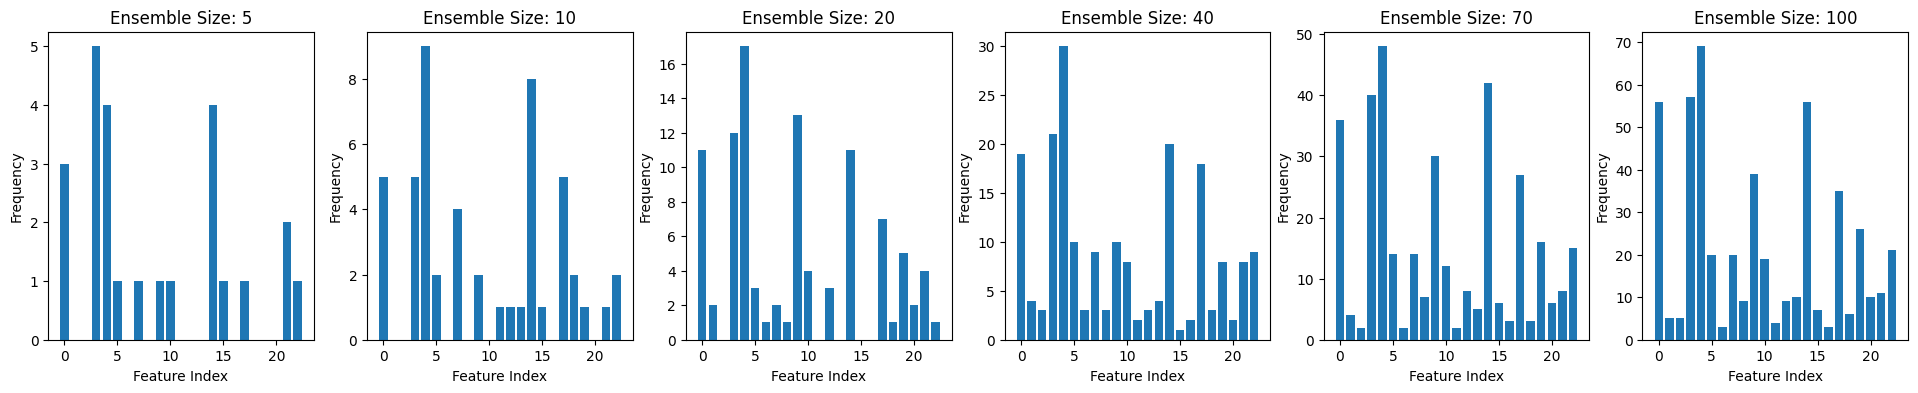

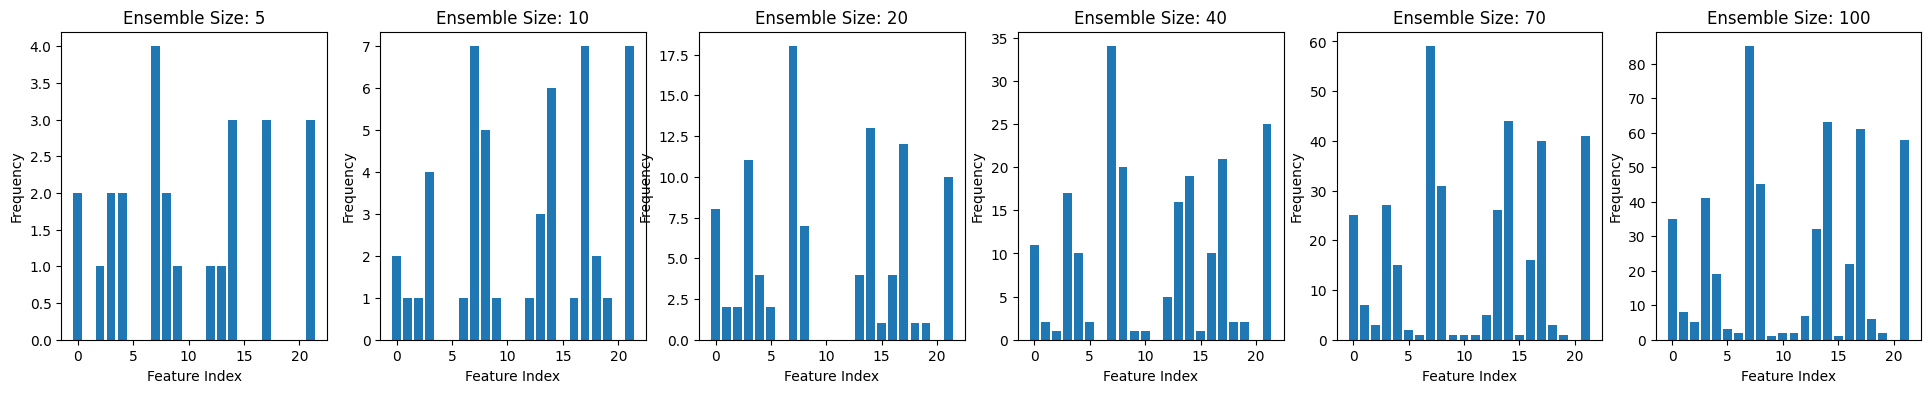

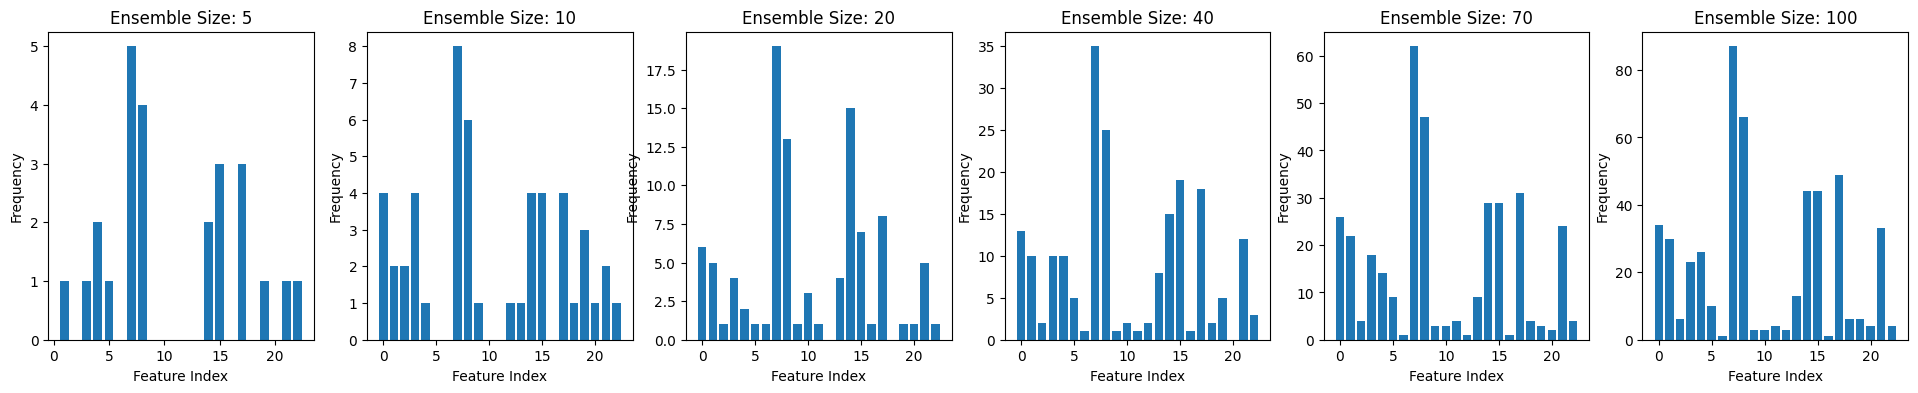

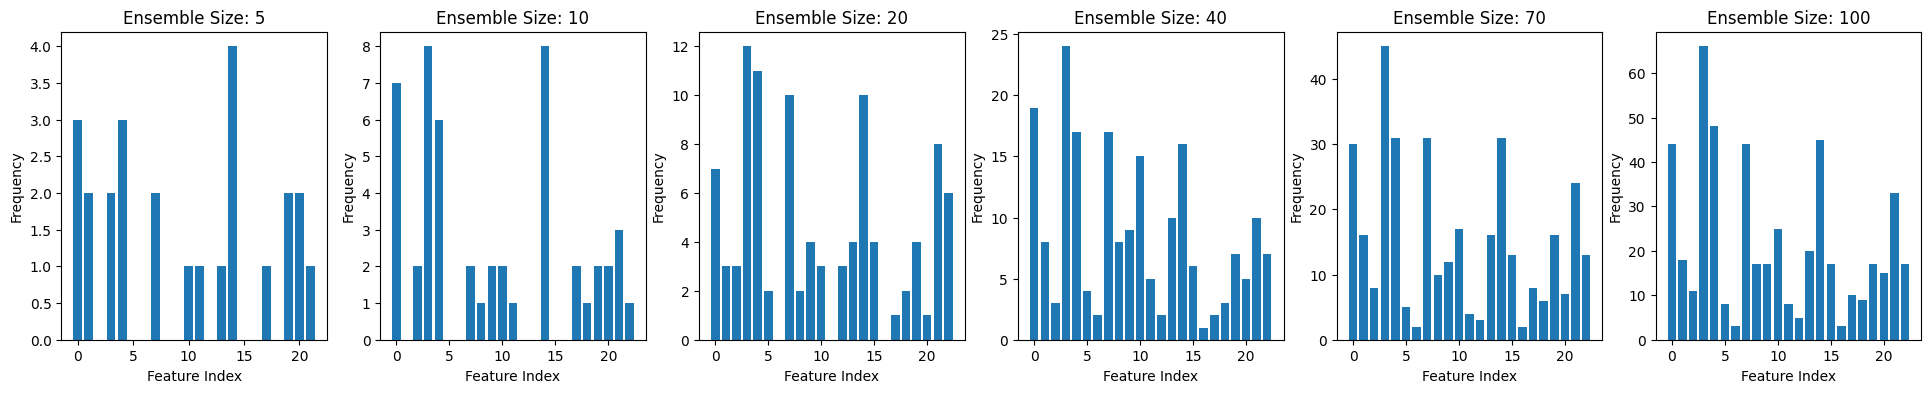

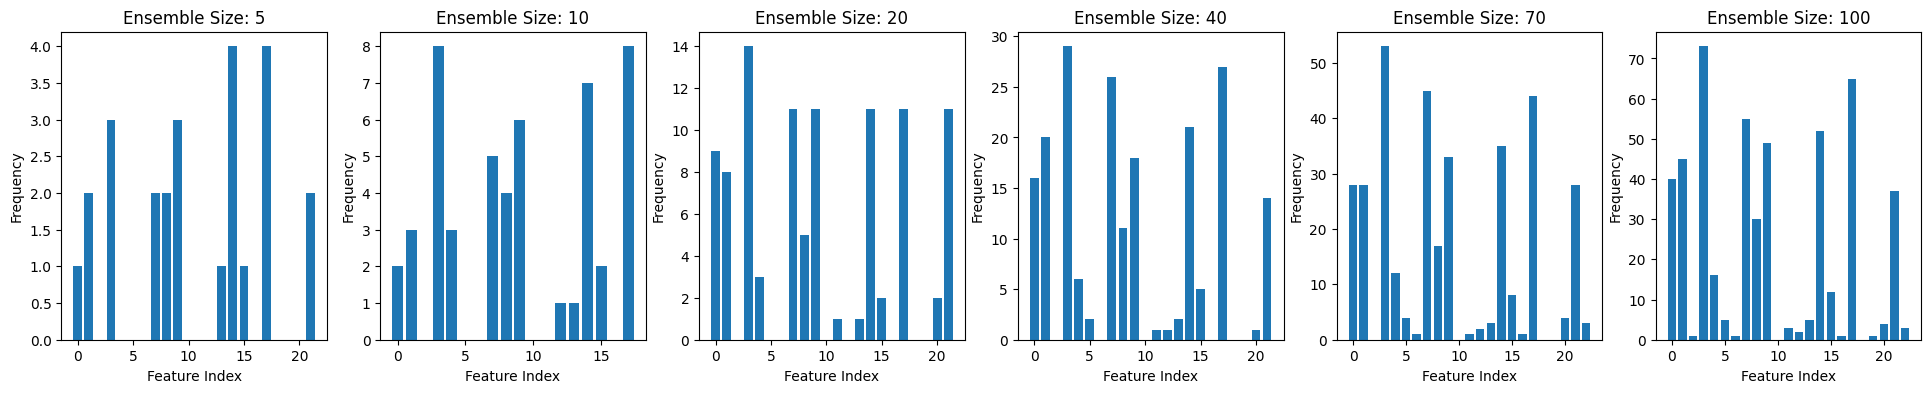

In [49]:
ensemble_sizes = [5, 10, 20, 40, 70, 100]
# Randomly sample size_ensemble indices from 0 to n_models for each ensemble size, load grads, and get top k grads
top5 = []
n_test = 5
counts = np.zeros((n_test, len(ensemble_sizes), n_features))
for i in range(n_test):
    fig, axs = plt.subplots(1, len(ensemble_sizes), figsize=(len(ensemble_sizes)*4, 4), dpi=100)
    for j, size_ensemble in enumerate(ensemble_sizes):
        indices = np.random.choice(n_models, size_ensemble, replace=False)  # should do this many times
        grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in indices])
        top5.append(np.array([get_top_k(grads[idx], k=5) for idx in range(size_ensemble)]))
        un, co = np.unique(top5[j][:, i].flatten(), return_counts=True)
        axs[j].bar(un, co)
        axs[j].set_xlabel('Feature Index')
        axs[j].set_ylabel('Frequency')
        axs[j].set_title(f'Ensemble Size: {size_ensemble}')
        counts[i, j, un] = co
    plt.show()

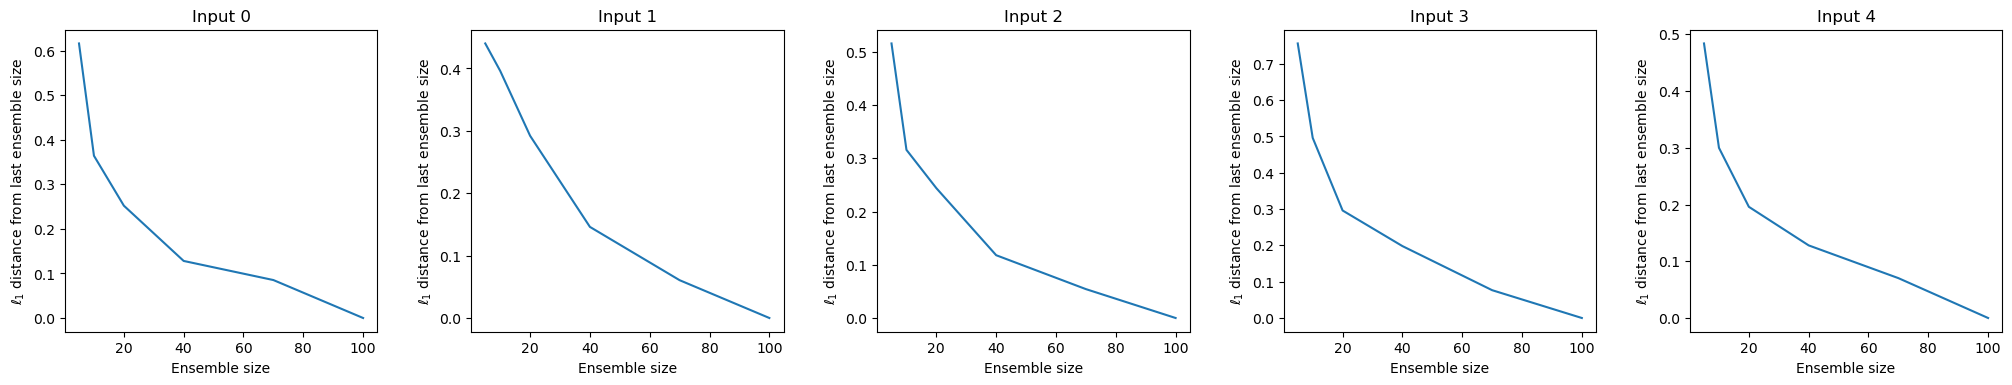

In [41]:
fig, axs = plt.subplots(1, n_test, figsize=(n_test*5, 4), dpi=100)
plt.subplots_adjust(wspace=0.3)
for i in range(n_test):
    counts_norm = counts[i]/np.sum(counts[i], axis=1)[:, None]
    axs[i].plot(ensemble_sizes, np.linalg.norm(counts_norm-counts_norm[-1], axis=1, ord=1))
    axs[i].set_xlabel('Ensemble size')
    axs[i].set_ylabel('$\ell_1$ distance from last ensemble size')
    axs[i].set_title(f'Input {i}')
plt.show()

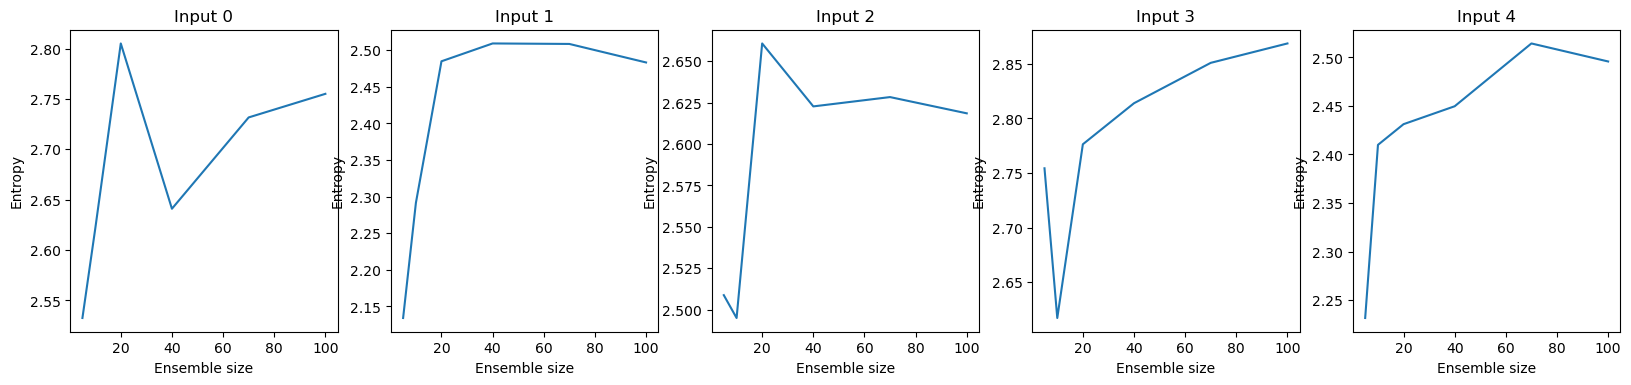

In [20]:
# Compute entropy of each feature distribution in counts
from scipy.stats import entropy
# Plot entropy of counts for each input
fig, axs = plt.subplots(1, n_test, figsize=(n_test*4, 4), dpi=100)
for i in range(n_test):
    full_counts_norm = counts[i, -1]/np.sum(counts[i, -1])
    counts[0]/np.sum(counts[0], axis=1)[:, None]
    axs[i].plot(ensemble_sizes, entropy(counts[i], axis=1))
    axs[i].set_xlabel('Ensemble size')
    axs[i].set_ylabel('Entropy')
    axs[i].set_title(f'Input {i}')
plt.show()